<a href="https://colab.research.google.com/github/sungkim11/forecast-stock-price/blob/main/Predict_Stock_Price_Orbit_2days.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Stock Price Using Orbit

## 1. Prerequisites

Following are prerequisite for this tutorial:
- Stock Price Data
- Python Package: Uber Orbit
- Python Package: pandas-datareader


### 1.1. Stock Price Data

Daily Stock Price Data is sourced from Yahoo using pandas-datareader.

### 1.2. Python Packages

#### 1.2.1. Update pandas-datareader 

It seems if you are using Google Colab, you will need to update pandas-datareader package every single time.

In [1]:
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 109 kB 13.4 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


#### 1.2.2. Install Uber Orbit

It seems if you are using Google Colab, you will need to install orbit-ml package every single time then RESTART RUNTIME then install orbit-ml package again.

In [1]:
!pip install orbit-ml

## 2. Code

### 2.1. Import Python Packages

Import python packages and show its version. Showing version is important since it will enable other users to replicate your work using same python version and python packages version.

In [2]:
import pandas as pd
import matplotlib as plt
import platform

import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas_datareader
from pandas_datareader import data as web

import orbit
#from orbit.models import DLT
from orbit.models import LGT
from orbit.diagnostics.plot import plot_predicted_data,plot_predicted_components, plot_bt_predictions
from orbit.diagnostics.backtest import BackTester, TimeSeriesSplitter
from orbit.diagnostics.metrics import smape, wmape

print('Python: ', platform.python_version())
print('pandas: ', pd.__version__)
print('matplotlib: ', plt.__version__)
print('statsmodels: ', statsmodels.__version__)
print('pandas_datareader: ', pandas_datareader.__version__)
print('Orbit: ', orbit.__version__)

Python:  3.7.13
pandas:  1.3.5
matplotlib:  3.5.1
statsmodels:  0.13.2
pandas_datareader:  0.10.0
Orbit:  1.1.2


### 2.2. Import Stock Price Data from Yahoo Finance

We will be forecasting stock price of AMD where we will use NASDAQ price or QQQ as a regressor.

We will be pulling 2 years of stock price data of both AMD and QQQ where we will use first 12 months of stock price data to train the model and second 12 months of stock price data to test and validate the model performance.

In [3]:
twenty_four_months = date.today() + relativedelta(months=-24)

stock_price = web.DataReader('AMD', 'yahoo', twenty_four_months)
stock_price.reset_index(inplace=True)
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       505 non-null    datetime64[ns]
 1   High       505 non-null    float64       
 2   Low        505 non-null    float64       
 3   Open       505 non-null    float64       
 4   Close      505 non-null    float64       
 5   Volume     505 non-null    int64         
 6   Adj Close  505 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 27.7 KB


In [4]:
nasdaq_price = web.DataReader('QQQ', 'yahoo', twenty_four_months)
nasdaq_price.reset_index(inplace=True)
nasdaq_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       505 non-null    datetime64[ns]
 1   High       505 non-null    float64       
 2   Low        505 non-null    float64       
 3   Open       505 non-null    float64       
 4   Close      505 non-null    float64       
 5   Volume     505 non-null    float64       
 6   Adj Close  505 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 27.7 KB


### 2.3. Prep Stock Price Data

To simplify the data prep steps, we will drop columns we will not use from nasdaq_price dataframe as well as rename 'Adj Close' to 'nadaq' since stock_price dataframe also has 'Adj Close' column name.

In [5]:
nasdaq_price = nasdaq_price[['Date', 'Adj Close']]
nasdaq_price.rename(columns={'Adj Close': 'nasdaq'}, inplace=True)
nasdaq_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    505 non-null    datetime64[ns]
 1   nasdaq  505 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 KB


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We will join both stock_price dataframe and nasdaq_price dataframe using 'Date'

In [6]:
stock_price = pd.merge(stock_price, nasdaq_price, on='Date', how="left")
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 0 to 504
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       505 non-null    datetime64[ns]
 1   High       505 non-null    float64       
 2   Low        505 non-null    float64       
 3   Open       505 non-null    float64       
 4   Close      505 non-null    float64       
 5   Volume     505 non-null    int64         
 6   Adj Close  505 non-null    float64       
 7   nasdaq     505 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 35.5 KB


We will name 'Adj Close' to 'adj_close' since I really do not like to having a space in column name.

In [7]:
stock_price.rename(columns={'Adj Close': 'adj_close'}, inplace=True)
stock_price.head(5)

,Date,High,Low,Open,Close,Volume,adj_close,nasdaq
0,2020-04-30,54.290001,52.029999,53.430000,52.389999,65543900,52.389999,216.820709
1,2020-05-01,51.950001,49.090000,51.070000,49.880001,69562700,49.880001,210.709579
2,2020-05-04,52.610001,49.730000,49.820000,52.560001,62590600,52.560001,213.165909
3,2020-05-05,53.509998,51.290001,53.430000,52.189999,56560500,52.189999,215.582626
4,2020-05-06,53.310001,51.880001,52.419998,52.160000,48138100,52.160000,216.909821


Let's split the dataset evenly to both train and test:
- train dataset
- test dataset

In [8]:
stock_price_train = stock_price[:-253]
stock_price_test = stock_price[-253:]

print('Train: ', stock_price_train.shape)
print('Test: ', stock_price_test.shape)

Train:  (252, 8)
Test:  (253, 8)


### 2.4. Develop Forecast Model

We will use Local Global Trend (LGT) with Markov Chain Monte Carlo (MCMC) sampling with point estimate.

In [9]:
%%time
stock_price_lgt = LGT(
  response_col='adj_close', 
  date_col='Date',  
  estimator='stan-mcmc',
  regressor_col=['nasdaq'],
  seed=8898,
  num_warmup=500,
  num_sample=1000,
  n_bootstrap_draws=100,
  prediction_percentiles=[10, 90],
)
stock_price_lgt.fit(df=stock_price_train) #, point_method='mean')

/usr/local/lib/python3.7/dist-packages/orbit/forecaster/forecaster.py:292: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aea89cc15436811b43e6c7a717ca27b7 NOW.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 125 and samples(per chain): 250.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 3.03 s, sys: 455 ms, total: 3.49 s
Wall time: 5min 18s


In [10]:
stock_price_predicted = stock_price_lgt.predict(df=stock_price_test, decompose=True) #, point_method='mean')

/usr/local/lib/python3.7/dist-packages/orbit/forecaster/forecaster.py:337: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


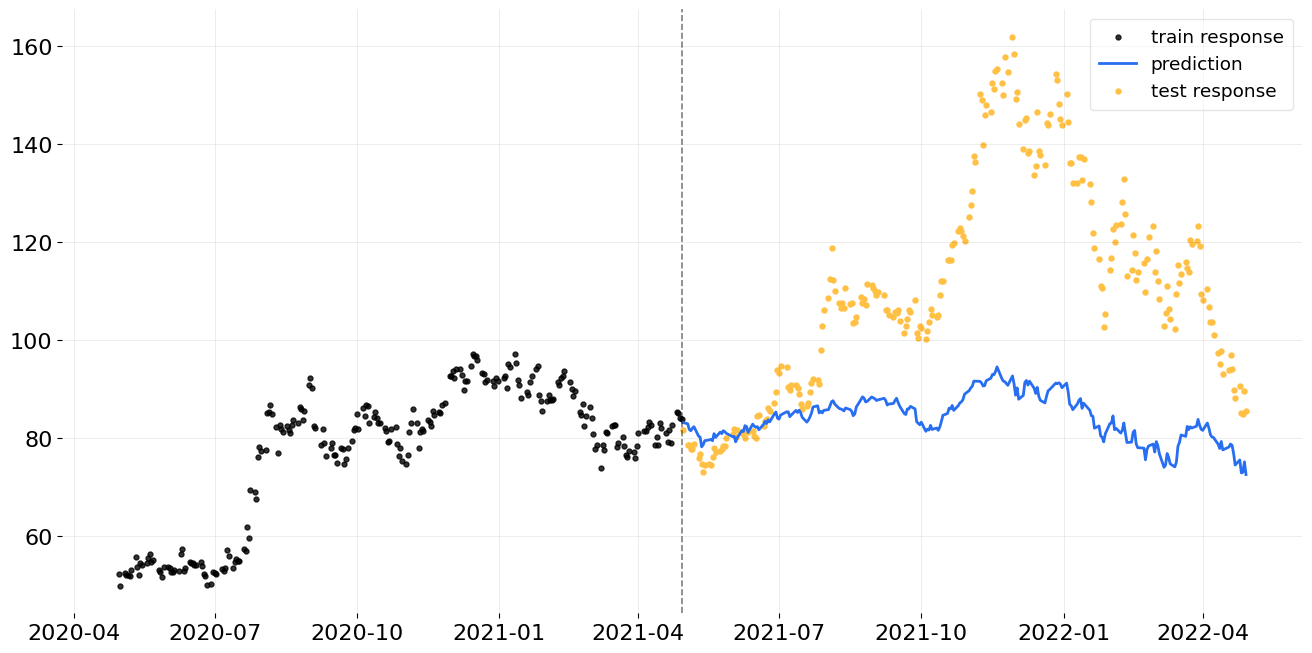

<AxesSubplot:>

In [11]:
plot_predicted_data(
  training_actual_df=stock_price_train, 
  predicted_df=stock_price_predicted, 
  date_col=stock_price_lgt.date_col, 
  actual_col=stock_price_lgt.response_col,
  test_actual_df=stock_price_test
)

In [12]:
stock_price_predicted.tail(10)

,Date,prediction_10,prediction,prediction_90,trend_10,trend,trend_90,seasonality_10,seasonality,seasonality_90,regression_10,regression,regression_90
243,2022-04-18,72.059707,78.200527,104.734222,0.000000,6.551899,33.108288,0.0,0.0,0.0,70.308765,71.806967,72.343816
244,2022-04-19,73.636077,78.807139,105.978469,0.020478,5.642301,33.724599,0.0,0.0,0.0,71.880226,73.411913,73.960761
245,2022-04-20,72.332572,78.550289,105.696120,0.194913,6.401275,32.911869,0.0,0.0,0.0,70.831891,72.341239,72.882083
246,2022-04-21,71.235099,76.895282,103.148248,0.528953,6.109512,32.228679,0.0,0.0,0.0,69.366304,70.844422,71.374075
247,2022-04-22,69.700677,74.521455,98.553650,0.706114,5.600764,31.413640,0.0,0.0,0.0,67.549888,68.989301,69.505084
248,2022-04-25,70.750162,75.562520,100.169618,1.229052,5.894249,31.180278,0.0,0.0,0.0,68.417614,69.875517,70.397926
249,2022-04-26,67.324962,72.915373,96.500327,0.591046,5.997775,29.302260,0.0,0.0,0.0,65.835197,67.238071,67.740762
250,2022-04-27,67.450104,73.060993,98.390178,0.571316,6.411028,30.955288,0.0,0.0,0.0,65.756311,67.157505,67.659593
251,2022-04-28,69.947088,75.175013,99.855923,0.120618,5.652105,30.017772,0.0,0.0,0.0,68.091702,69.542660,70.062581
252,2022-04-29,66.842085,72.581485,96.532448,0.348432,6.280318,31.055015,0.0,0.0,0.0,65.027667,66.413334,66.909859


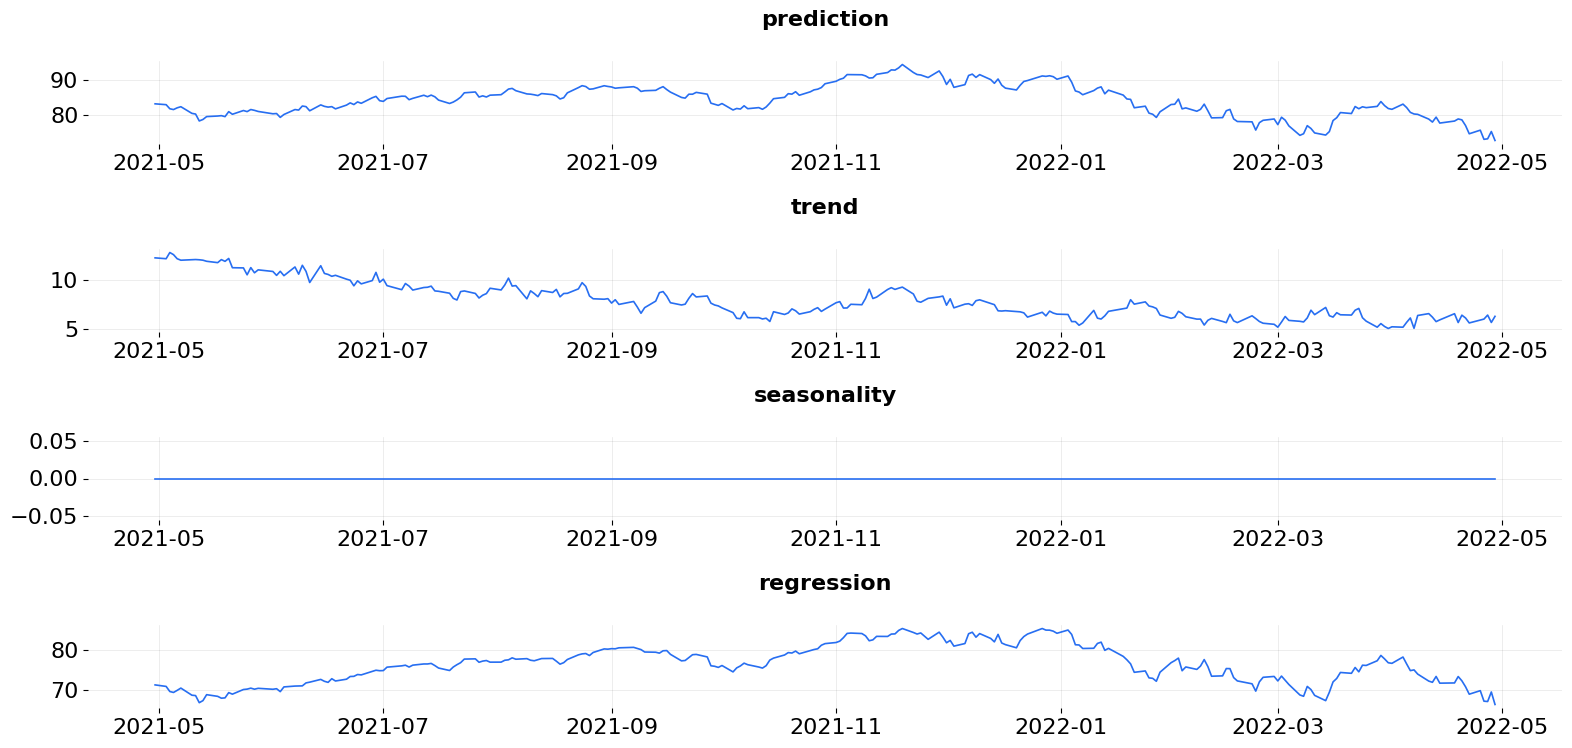

array([<AxesSubplot:title={'center':'prediction'}>,
       <AxesSubplot:title={'center':'trend'}>,
       <AxesSubplot:title={'center':'seasonality'}>,
       <AxesSubplot:title={'center':'regression'}>], dtype=object)

In [13]:
 plot_predicted_components(stock_price_predicted, 
                           date_col='Date',
                           plot_components=['prediction', 'trend', 'seasonality', 'regression'])

### 2.5. Backtest Forecast Model

We know Forecast model will not perform well predicting stock price, but we are not trying to predict the stock price for one year. We are trying to predict stock price for next day. We have configured the rolling backtest where we train using 10 days of data to predict stock price for both 11th. day and 12th. day. Fortunately, Orbit's backtest functionality EXCELS at this. Here, we will be testing performance of the model for 246 iterations of two days.

<AxesSubplot:title={'center':'Train/Test Split Scheme'}, ylabel='Split #'>

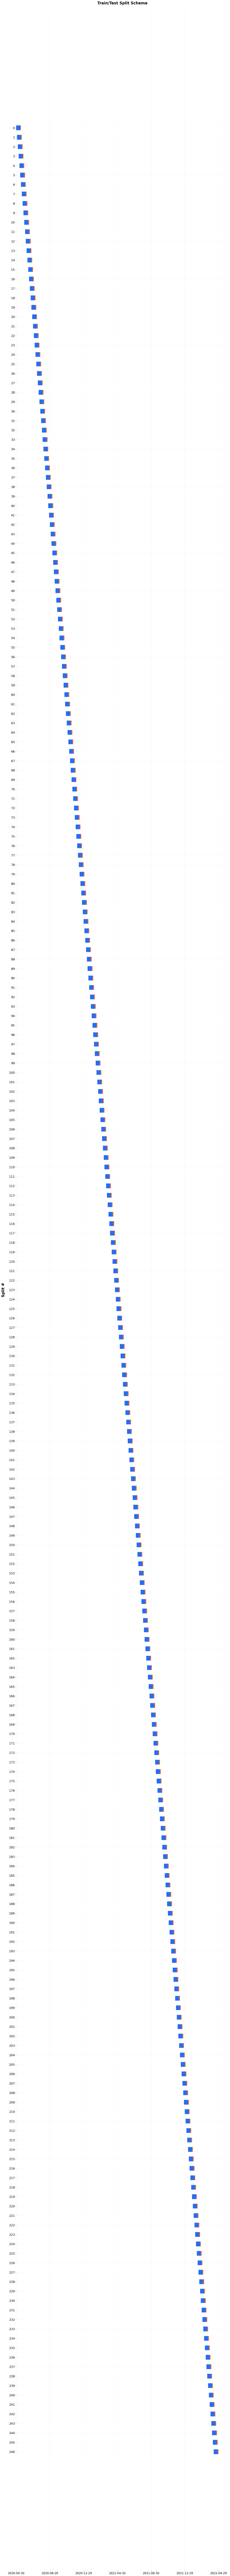

In [14]:
# configs
min_train_len = 10
forecast_len = 2
incremental_len = 2
window_type = 'rolling'

stock_price_bt = BackTester(
    model=stock_price_lgt,
    df=stock_price,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    window_type=window_type,
)

stock_price_splitter = stock_price_bt.get_splitter()
stock_price_splitter.plot()

In [18]:
%%time
stock_price_bt.fit_predict()

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 125 and samples(per chain): 250.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 125 and samples(per chain): 250.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 125 and samples(per chain): 250.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 125 and samples(per chain): 250.
/usr/local/lib/python3.7/dist-packages/orbit/forecaster/forecaster.py:292: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 125 and samples(per chain): 250.
/usr/local/lib/python3.7/dist-packages/orbit/forecaster/forecaster.py:337: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is no

CPU times: user 25.8 s, sys: 27 s, total: 52.8 s
Wall time: 15min 47s


/usr/local/lib/python3.7/dist-packages/orbit/forecaster/forecaster.py:337: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


In [19]:
predicted_df = stock_price_bt.get_predicted_df()
predicted_df.head(5)

,date,actual,prediction_10,prediction,prediction_90,training_data,split_key
0,2020-04-30,52.389999,50.401540,52.400536,54.840828,True,0
1,2020-05-01,49.880001,48.380142,51.556908,54.022174,True,0
2,2020-05-04,52.560001,48.397871,50.992232,53.308276,True,0
3,2020-05-05,52.189999,49.260760,52.569929,55.100804,True,0
4,2020-05-06,52.160000,49.837183,52.525479,55.299196,True,0


/usr/local/lib/python3.7/dist-packages/orbit/diagnostics/plot.py:424: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


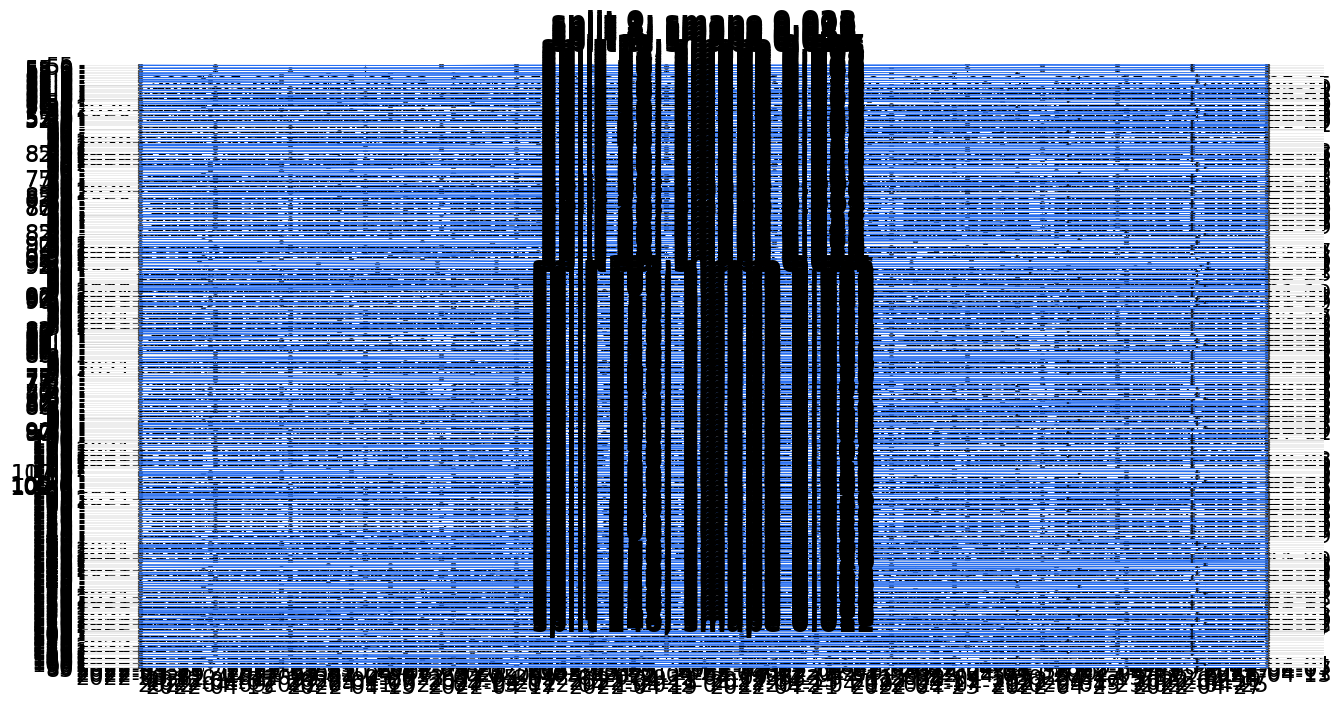

In [20]:
plot_bt_predictions(predicted_df, metrics=smape, ncol=1, include_vline=True);

The forecast model perfomed worsed than 1 day forecast with SMAPE of 0.0236. I will try more days in other notebooks.

In [21]:
stock_price_bt.score()

,metric_name,metric_values,is_training_metric
0,smape,0.023638,False
1,wmape,0.024321,False
2,mape,0.023575,False
3,mse,9.289655,False
4,mae,2.108730,False
5,rmsse,1.011887,False


In [22]:
stock_price_predicted.tail(5)

,Date,prediction_10,prediction,prediction_90,trend_10,trend,trend_90,seasonality_10,seasonality,seasonality_90,regression_10,regression,regression_90
248,2022-04-25,70.750162,75.562520,100.169618,1.229052,5.894249,31.180278,0.0,0.0,0.0,68.417614,69.875517,70.397926
249,2022-04-26,67.324962,72.915373,96.500327,0.591046,5.997775,29.302260,0.0,0.0,0.0,65.835197,67.238071,67.740762
250,2022-04-27,67.450104,73.060993,98.390178,0.571316,6.411028,30.955288,0.0,0.0,0.0,65.756311,67.157505,67.659593
251,2022-04-28,69.947088,75.175013,99.855923,0.120618,5.652105,30.017772,0.0,0.0,0.0,68.091702,69.542660,70.062581
252,2022-04-29,66.842085,72.581485,96.532448,0.348432,6.280318,31.055015,0.0,0.0,0.0,65.027667,66.413334,66.909859


In [23]:
predicted_df.tail(20)

,date,actual,prediction_10,prediction,prediction_90,training_data,split_key
2944,2022-04-14,93.059998,92.905868,94.485717,97.226097,True,245
2945,2022-04-18,93.889999,91.282360,93.432988,96.434771,True,245
2946,2022-04-19,96.930000,92.852527,95.046094,97.499467,True,245
2947,2022-04-20,94.019997,91.975901,94.554356,96.878226,True,245
2948,2022-04-21,89.849998,89.826407,92.029308,93.953774,True,245
2949,2022-04-22,88.139999,86.038095,88.200351,90.642499,True,245
2950,2022-04-25,90.690002,87.255344,89.432981,91.300865,False,245
2951,2022-04-26,85.160004,83.410338,86.069069,88.262577,False,245
2952,2022-04-12,95.099998,92.456236,95.001246,97.627053,True,246
2953,2022-04-13,97.739998,93.727170,96.075015,98.201709,True,246
